In [1]:
%load_ext zipline

In [2]:
%load_ext watermark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Импортируем библиотеки

In [4]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style

# работа с временем
from datetime import datetime

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

In [5]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
%watermark --iversions

numpy   1.11.1
pandas  0.18.1
zipline v1.3.0
pytz    2016.6.1
pyfolio 0.9.2



# 2. Загрузка данных

In [7]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

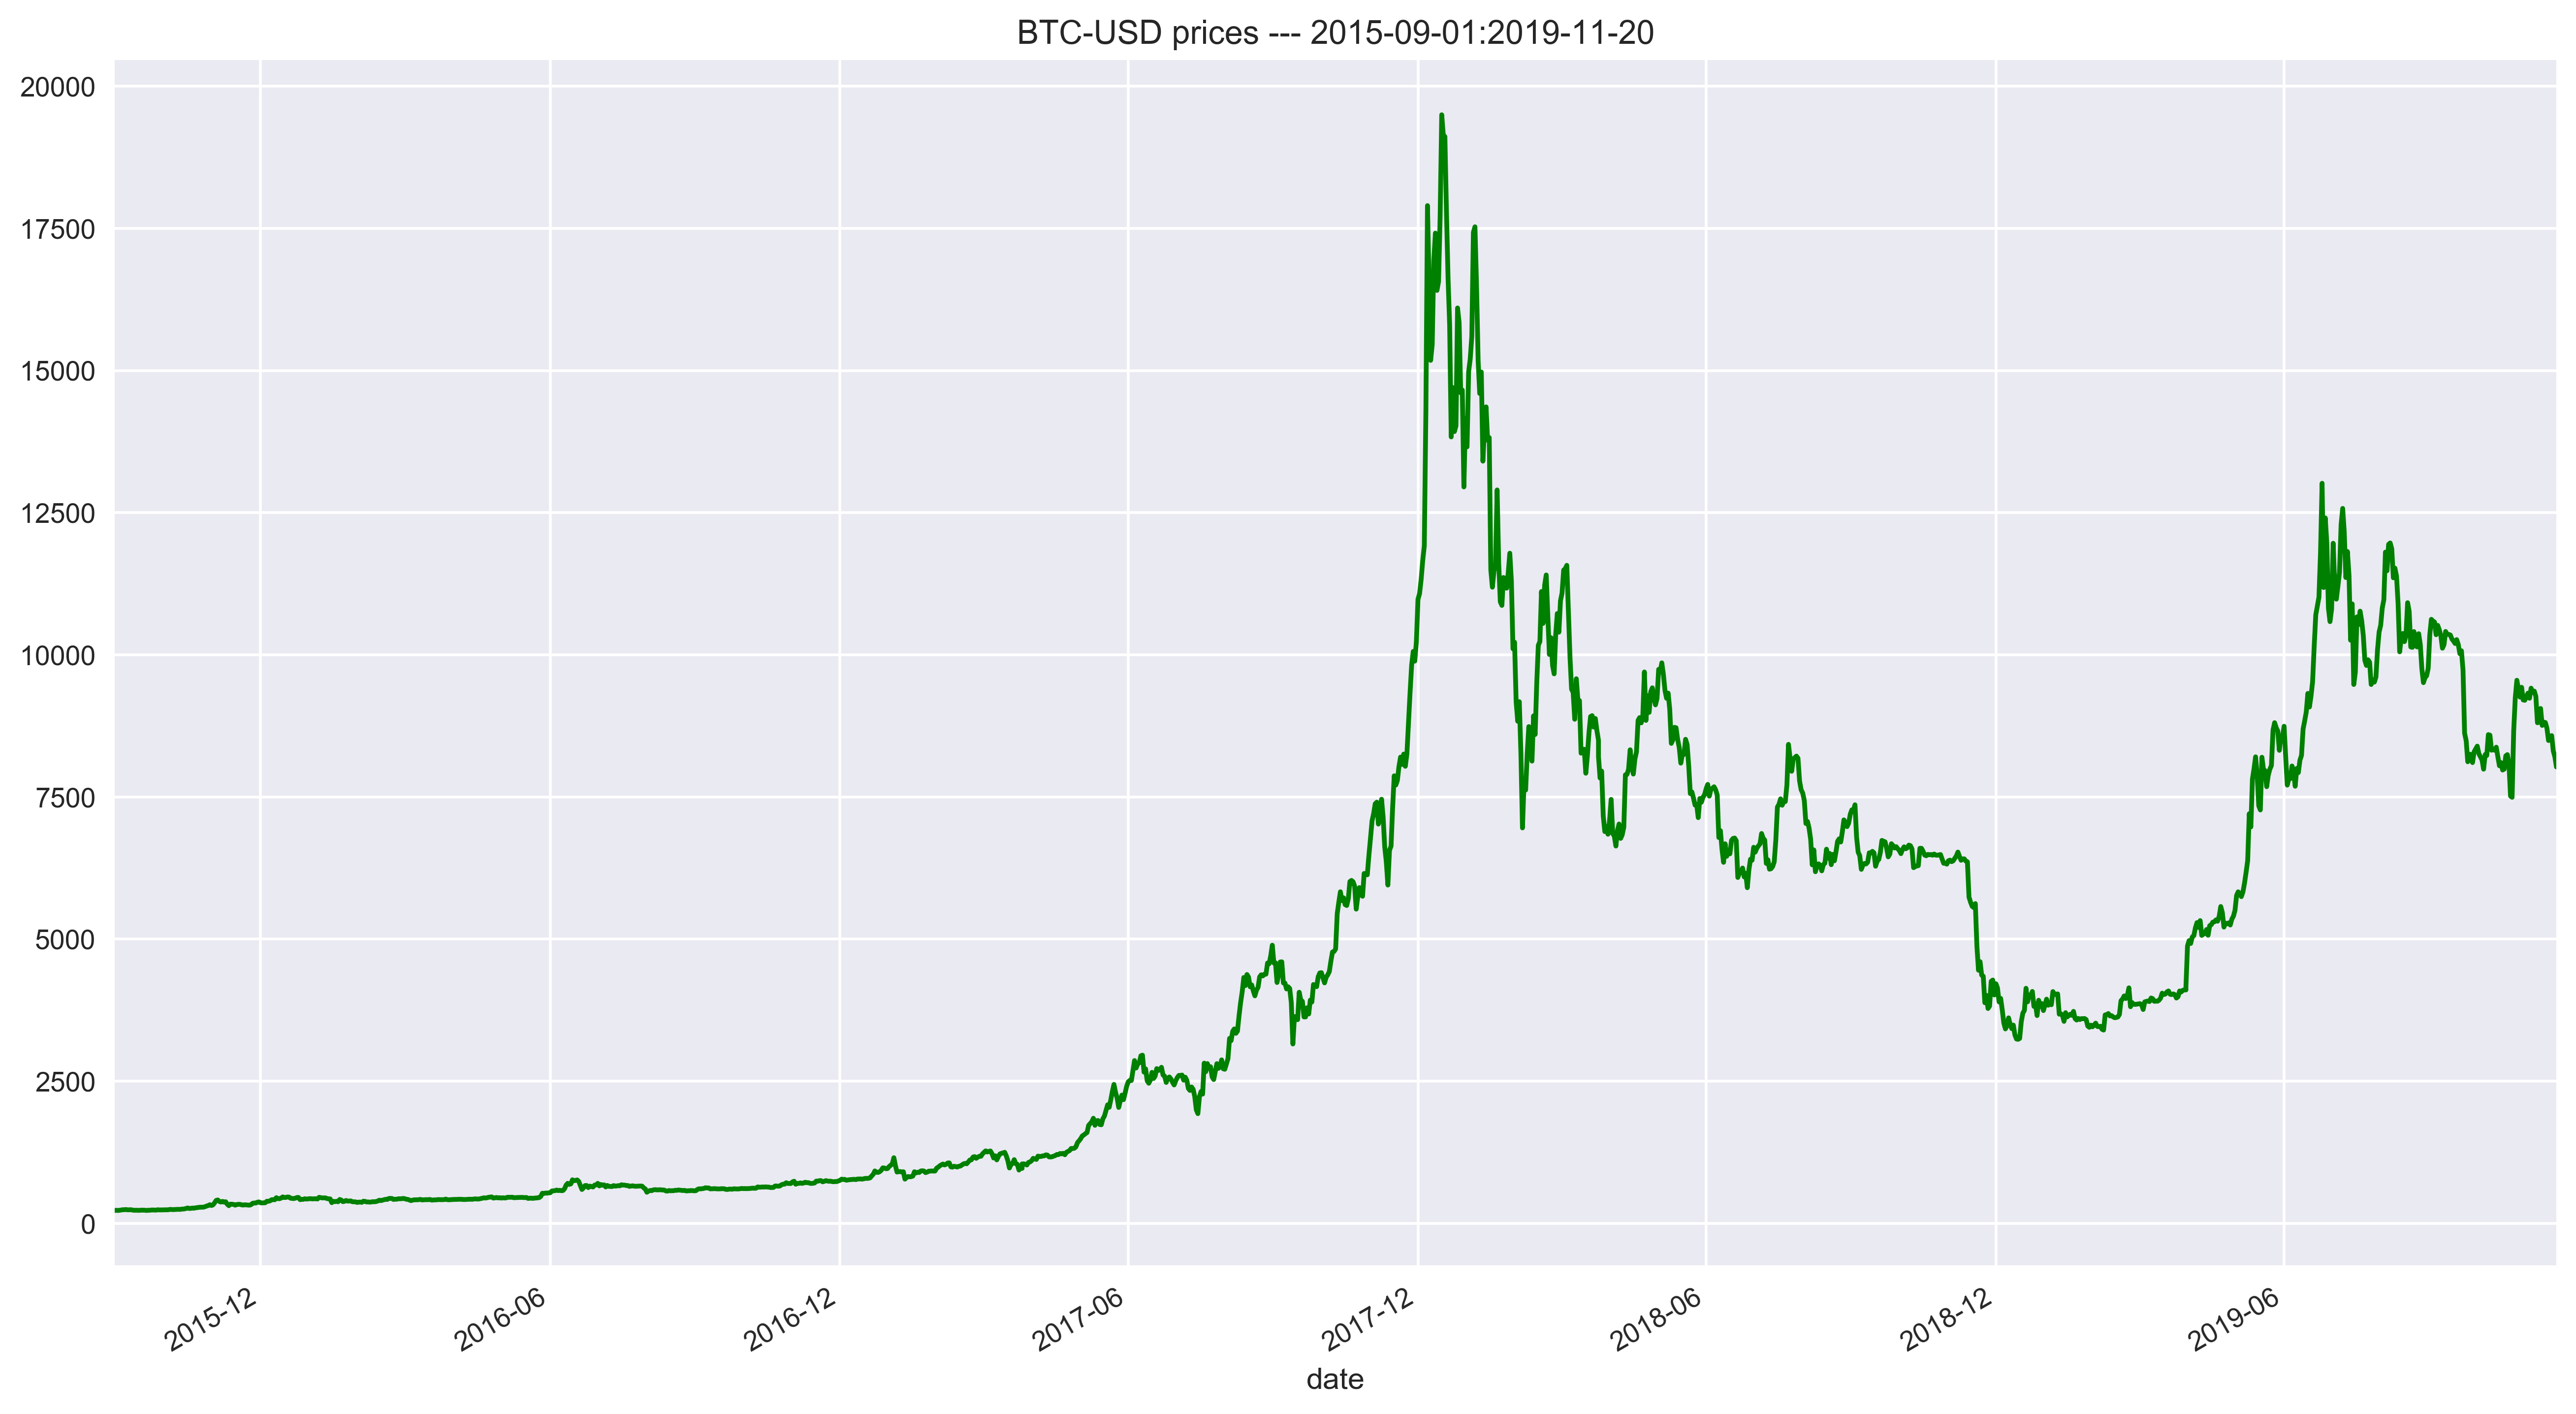

In [8]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-09-01', 
                  end_date='2019-11-20', 
                  freq='daily', 
                  path='data/BTC.csv')

In [9]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-09-01', 
                  end_date='2019-11-20', 
                  freq='daily', 
                  path='data/ETH.csv')

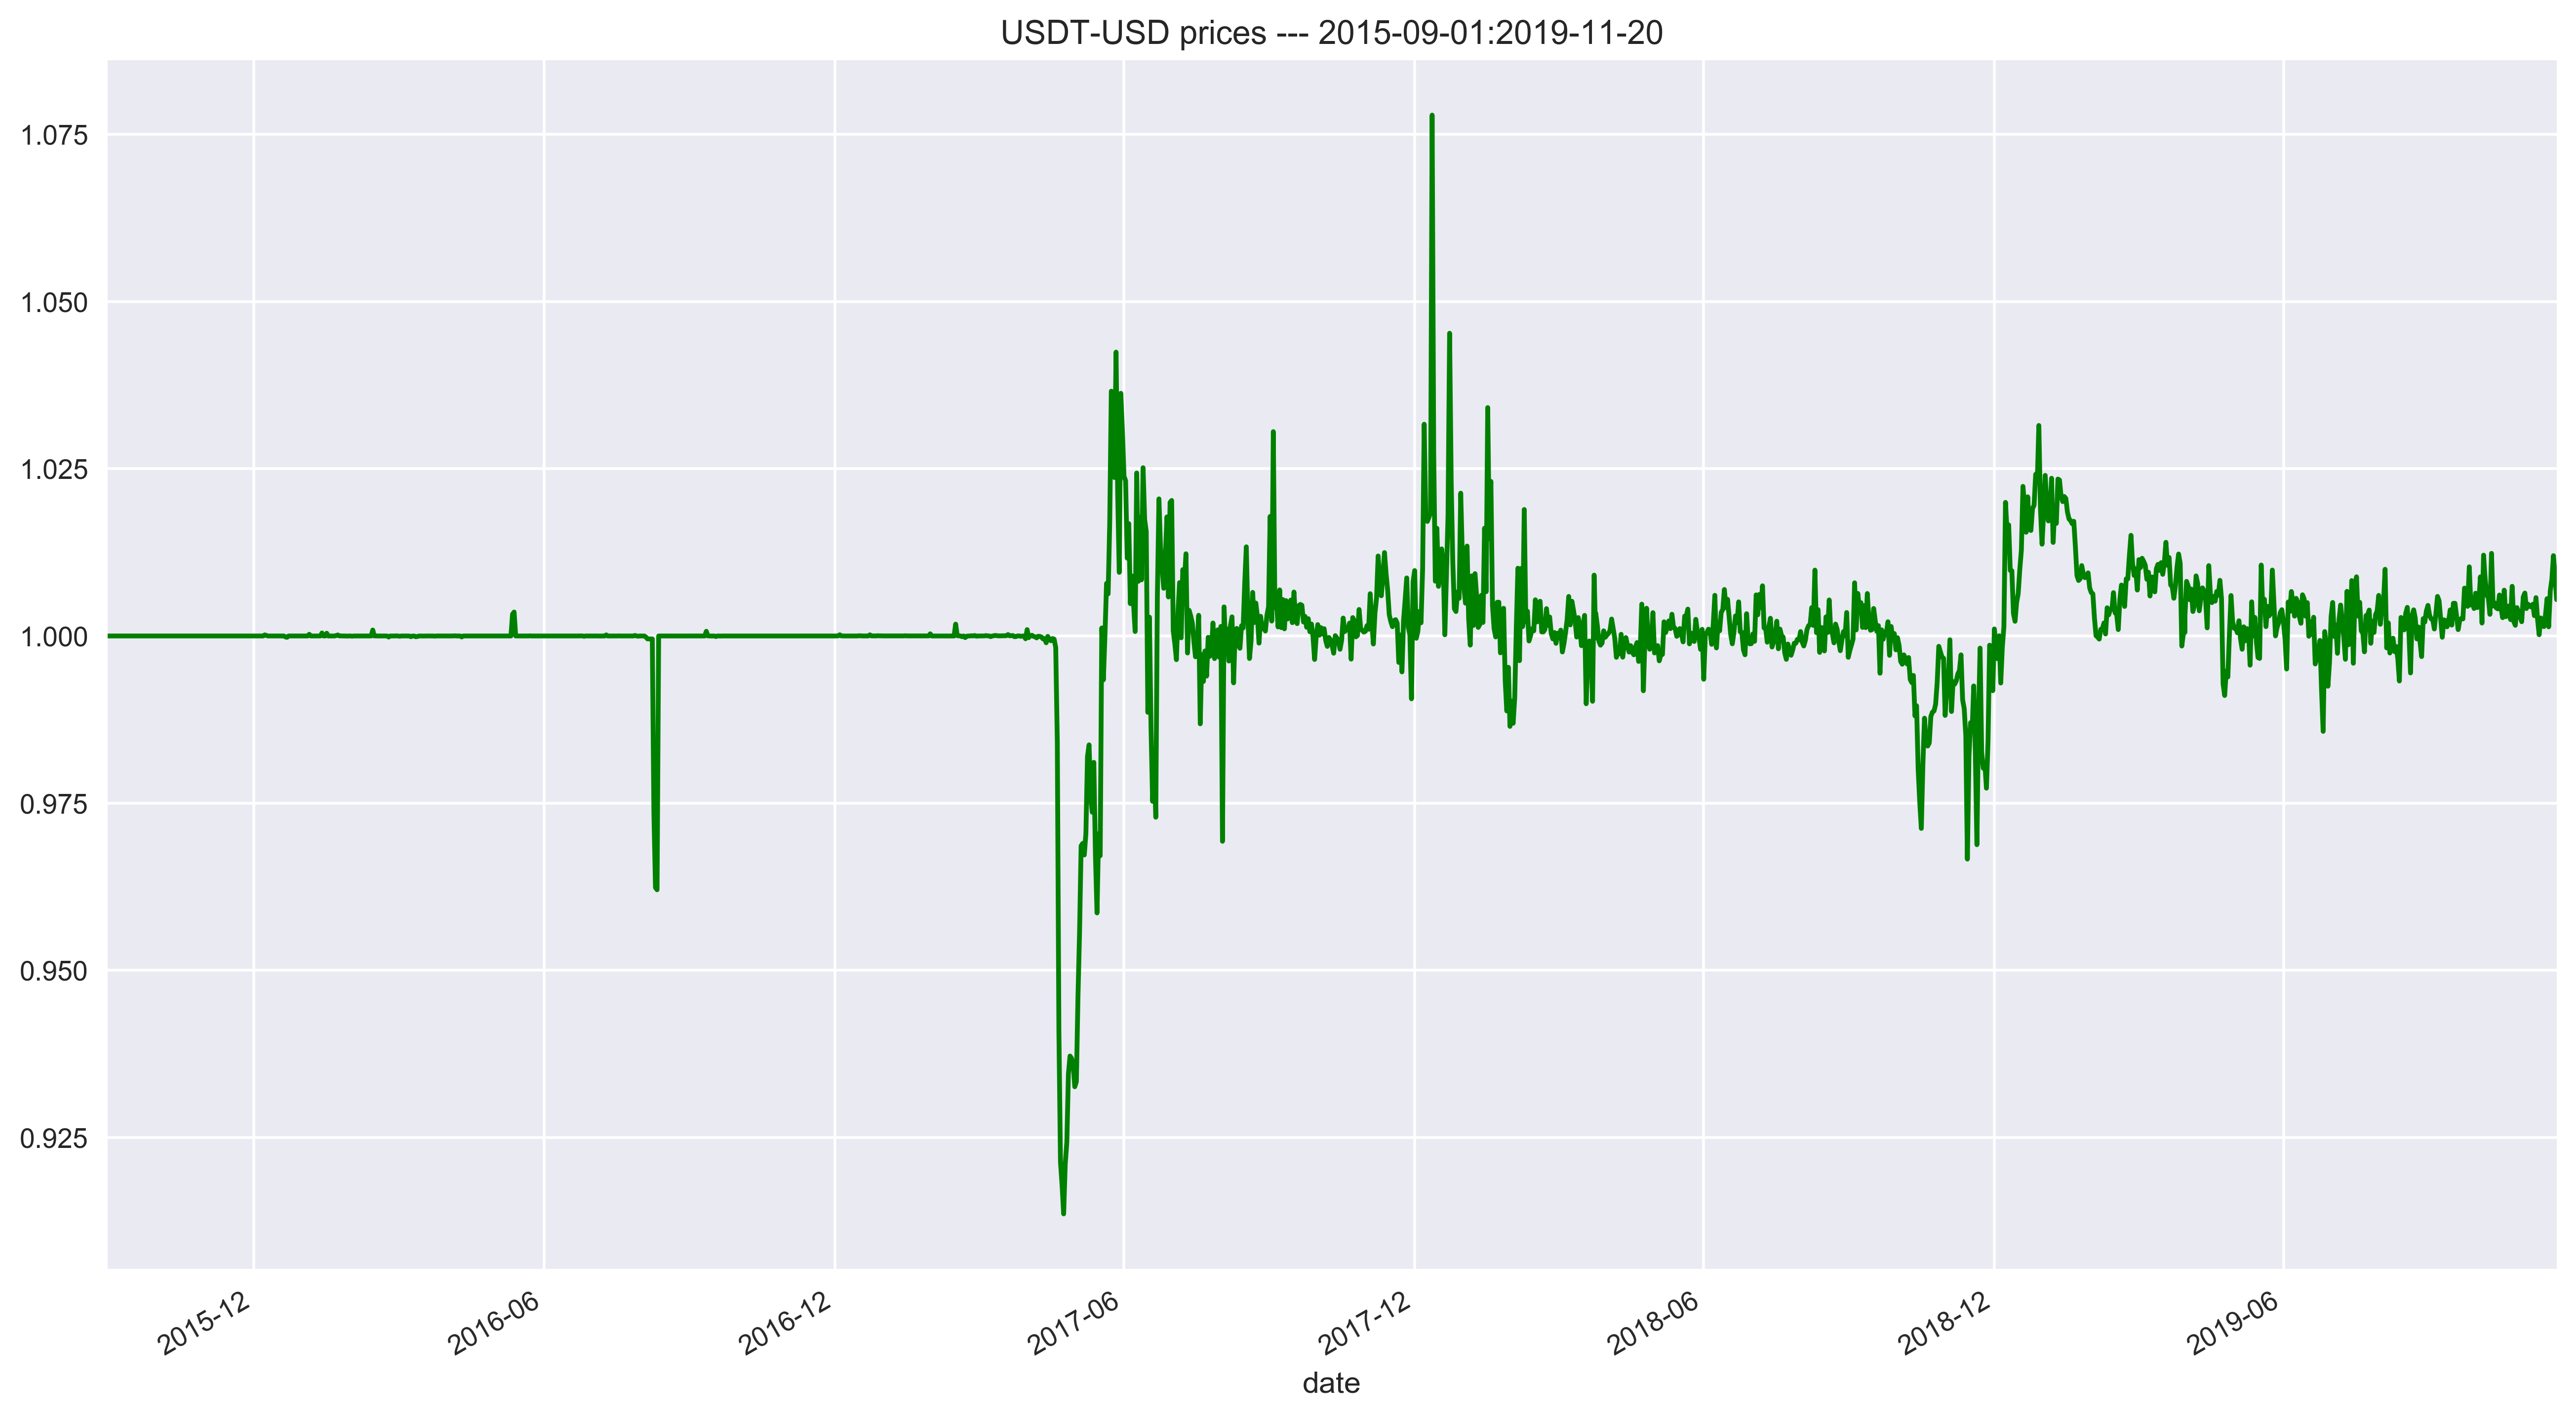

In [10]:
download_csv_data(ticker='USDT-USD', 
                  start_date='2015-09-01', 
                  end_date='2019-11-20', 
                  freq='daily', 
                  path='data/USDT.csv')

In [11]:
data = OrderedDict()

tikers = ["BTC", "ETH", "USDT"]

for tiker in tikers:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][["open","high","low","close","volume"]]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                  open        high         low       close      volume
date                                                                  
2015-08-31  230.255997  231.216003  226.860001  228.121002  20575200.0
2015-09-01  228.026993  230.576996  226.475006  229.283997  18760400.0
2015-09-02  229.324005  229.604996  226.667007  227.182999  17482000.0
2015-09-03  227.214996  230.899994  227.050995  230.298004  20962400.0
2015-09-04  230.199005  236.143005  229.442993  235.018997  20671400.0
               open     high      low    close    volume
date                                                    
2015-08-31  1.35348  1.39274  1.33663  1.35161  778862.0
2015-09-01  1.35157  1.35491  1.26462  1.29479  883769.0
2015-09-02  1.29519  1.30999  1.21103  1.26493  702991.0
2015-09-03  1.26493  1.30252  1.23681  1.27441  474391.0
2015-09-04  1.28056  1.34230  1.27119  1.33881  448453.0
            open  high  low  close   volume
date                                       
2015-08-31   1.0

In [12]:
data["BTC"].tail(10)

open         high          low        close        volume
date                                                                        
2019-11-11  9056.917969  9081.279297  8700.608398  8757.788086  2.026551e+10
2019-11-12  8759.751953  8853.768555  8685.427734  8815.662109  2.030977e+10
2019-11-13  8812.033203  8836.841797  8761.651367  8808.262695  1.754576e+10
2019-11-14  8811.936523  8826.943359  8692.551758  8708.094727  1.908474e+10
2019-11-15  8705.708008  8730.873047  8484.843750  8491.992188  2.179686e+10
2019-11-16  8491.166016  8591.997070  8473.973633  8550.760742  1.649539e+10
2019-11-17  8549.470703  8727.789062  8500.967773  8577.975586  1.866864e+10
2019-11-18  8573.980469  8653.280273  8273.573242  8309.286133  2.157947e+10
2019-11-19  8305.134766  8408.516602  8099.963379  8206.145508  2.108361e+10
2019-11-20  8203.613281  8237.240234  8010.511719  8027.268066  2.076430e+10

In [13]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 1543 (major_axis) x 5 (minor_axis)
Items axis: BTC to USDT
Major_axis axis: 2015-08-31 00:00:00+00:00 to 2019-11-20 00:00:00+00:00
Minor_axis axis: open to volume


# 3. Strategy A

## Определяем функции алгоритма

In [14]:
def initialize(context):
    
    # устанавливаем комиссию за сделку
    context.set_commission(commission.PerDollar(cost=0.0007))
    
    context.assets = symbols('BTC', 'ETH', 'USDT')
    context.n_assets = len(context.assets)
    
    context.window = 0
    
    context.rebalance_period = 30
    context.time = 0

После того, как алгоритм был инициализирован, zipline вызывает handle_data() функцию один раз для каждого события. При каждом вызове он передает одну context и ту же переменную и вызываемый фрейм события, data содержащий текущий торговый бар с ценами открытия, максимума, минимума и закрытия (OHLC), а также объем для каждой акции

In [15]:
def handle_data(context, data):
    weights = [0.55, 0.25, 0.2]
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        # extract prices
        prices = data.history(context.assets, fields='price',
                               bar_count=context.window + 1, frequency='1d')

        # submit orders
        for asset in context.assets:
            order_target_percent(asset, weights[asset])
    
    #record(weights=cleaned_weights)
    context.time += 1

## Запускаем алгоритм

In [16]:
max_sharpe_30_days_df = zipline.run_algorithm(start=datetime(2015, 11, 1, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 11, 20, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000,
                              handle_data=handle_data,
                              data=panel)

In [17]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(max_sharpe_30_days_df)

In [18]:
perf = max_sharpe_30_days_df

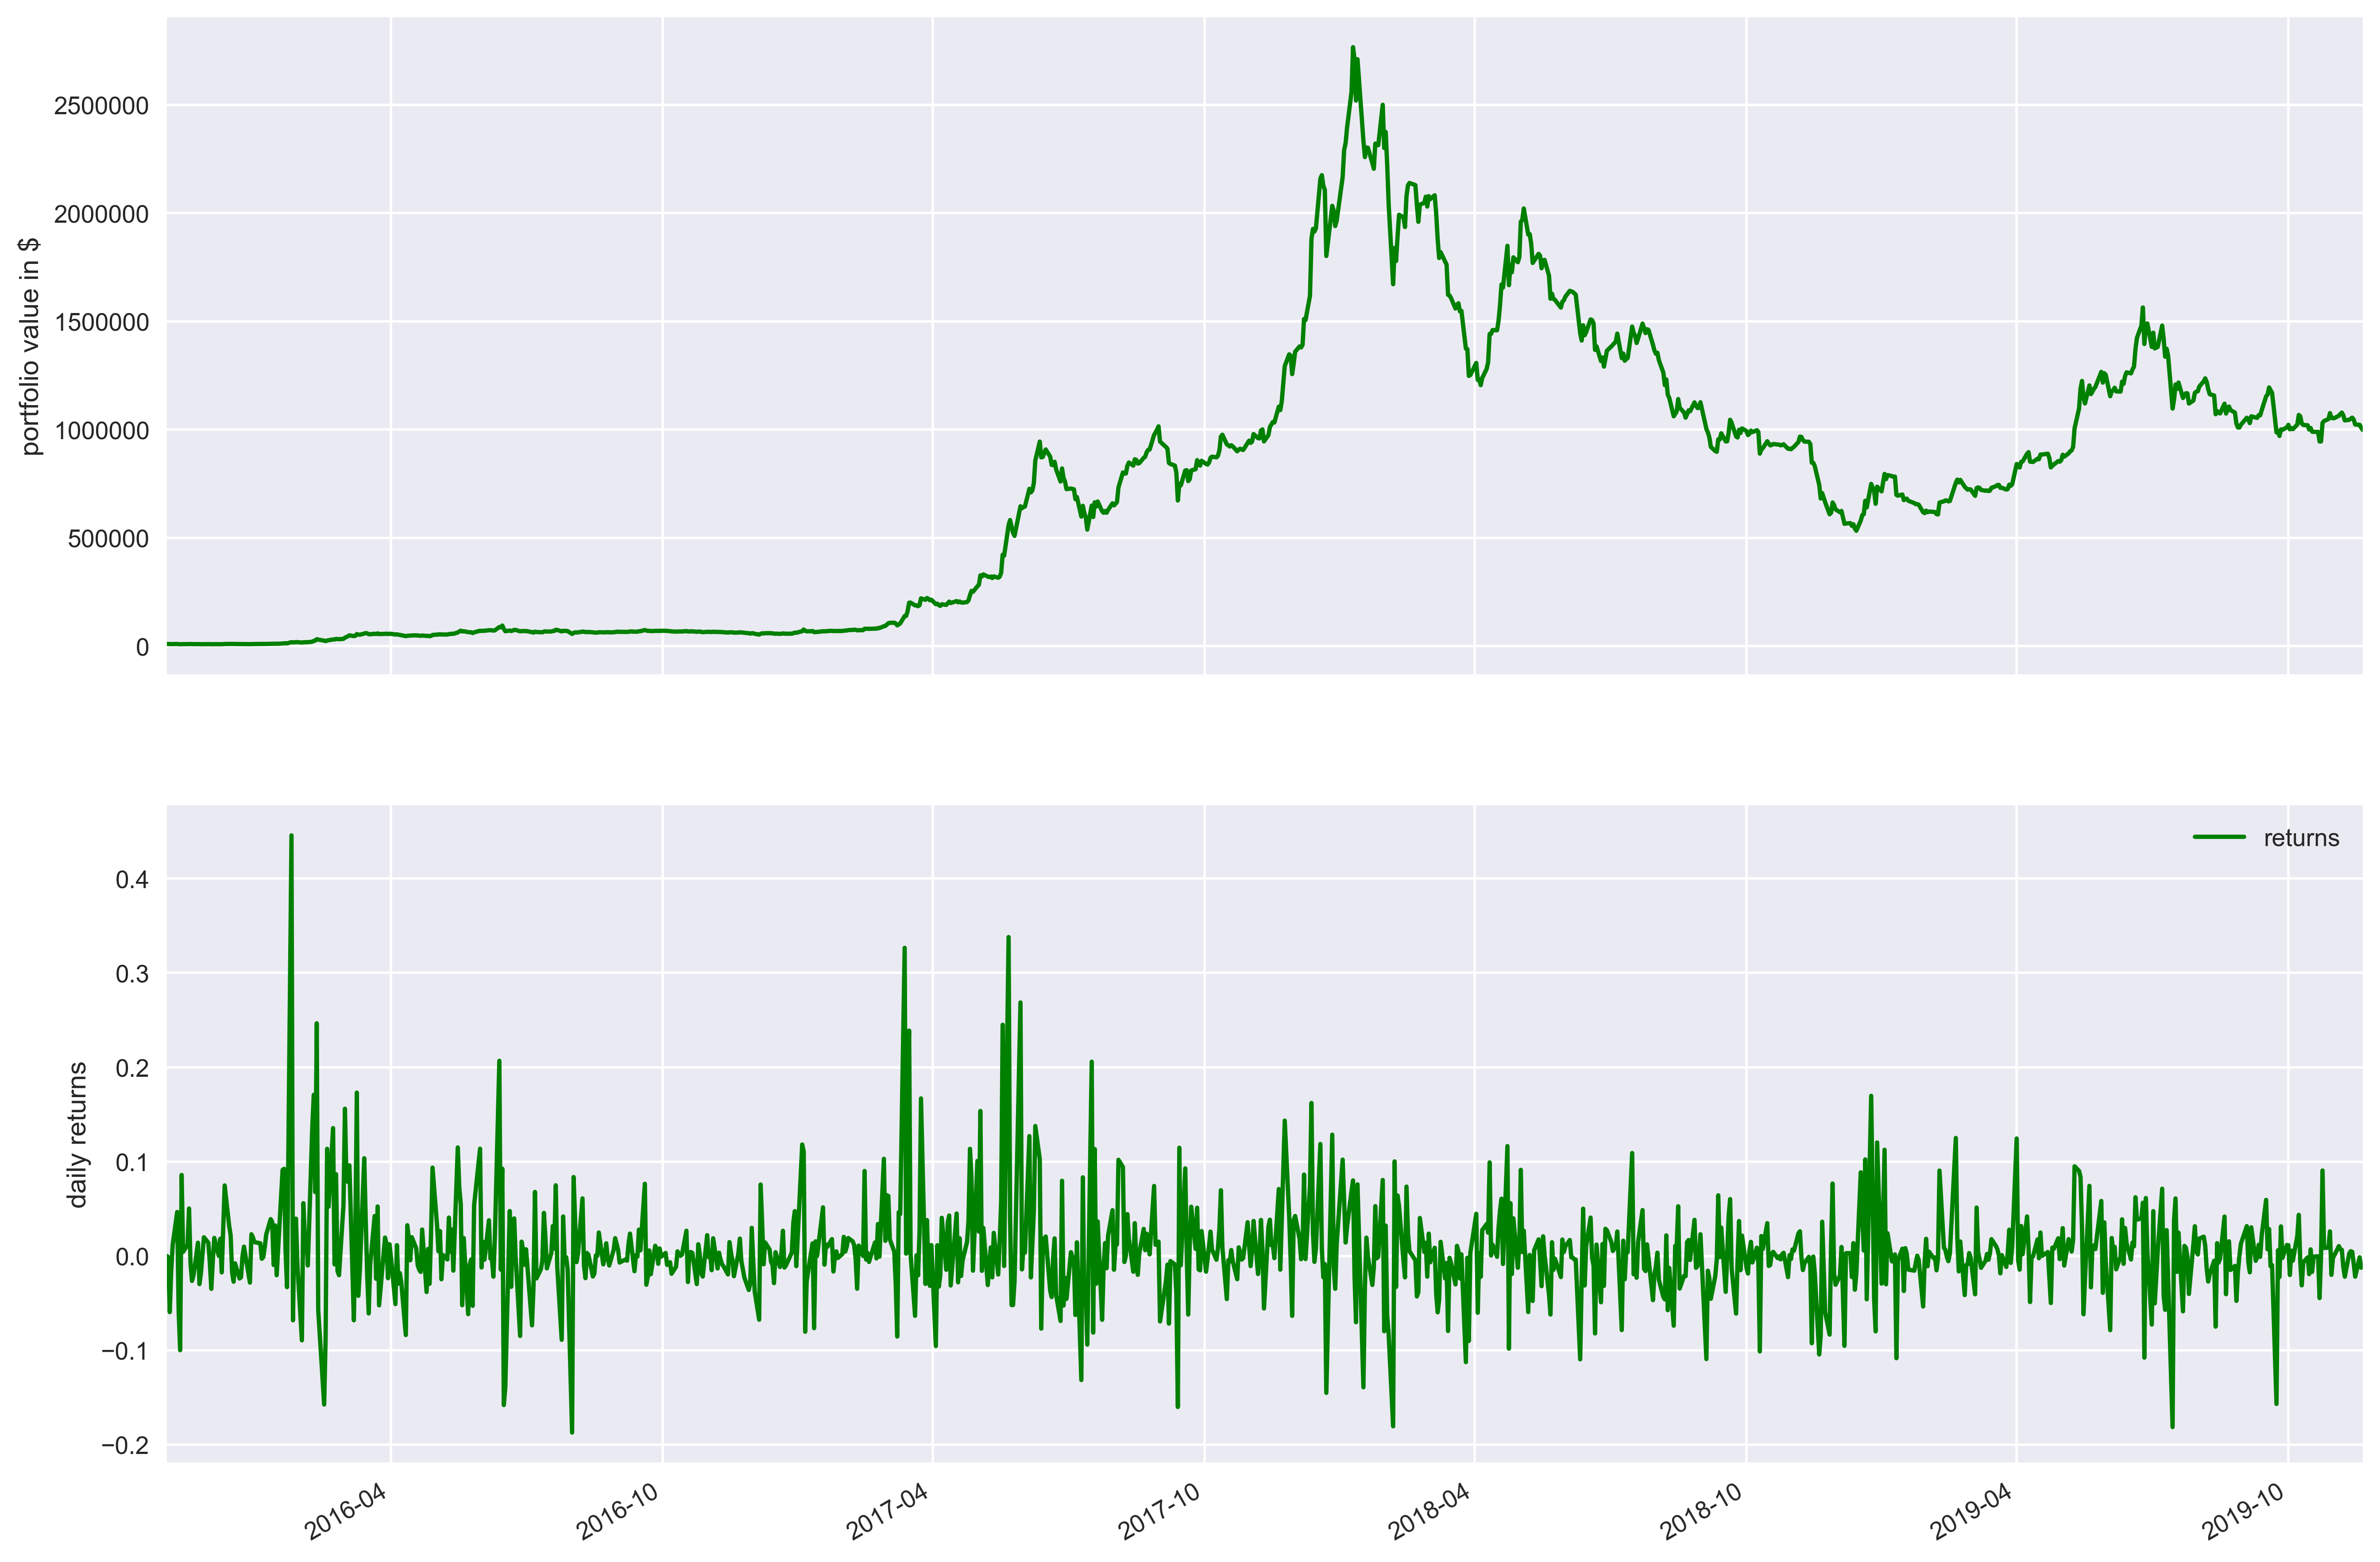

Final portfolio value (including cash): 998504.99$


In [19]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=[16, 12])

# portfolio value
perf.portfolio_value.plot(ax=ax[0], color='g')
ax[0].set_ylabel('portfolio value in $')

# daily returns
perf.returns.plot(ax=ax[1], color='g')
ax[1].set_ylabel('daily returns')

#fig.suptitle('Buy and Hold Strategy - BTC', fontsize=16)
plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

# Ребаллансировка

In [20]:
profit_6 = []

for period in range(2, 365):
    
    def initialize(context):
    
        # устанавливаем комиссию за сделку
        context.set_commission(commission.PerDollar(cost=0.0007))
    
        context.assets = symbols('BTC', 'ETH', 'USDT')
        context.n_assets = len(context.assets)
    
        context.window = 0
    
        context.rebalance_period = period
        context.time = 0
        
    def handle_data(context, data):
        weights = [0.55, 0.25, 0.2]
        if context.time == 0 or (context.time % context.rebalance_period == 0):

            # extract prices
            prices = data.history(context.assets, fields='price',
                                   bar_count=context.window + 1, frequency='1d')

            # submit orders
            for asset in context.assets:
                order_target_percent(asset, weights[asset])

        #record(weights=cleaned_weights)
        context.time += 1
        
    max_sharpe_30_days_df = zipline.run_algorithm(start=datetime(2015, 12, 1, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 10, 20, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000,
                              handle_data=handle_data,
                              data=panel)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(max_sharpe_30_days_df)
    
    perf = max_sharpe_30_days_df
    
    profit_6.append(np.round(perf.portfolio_value[-1], 2))

In [24]:
#k1 = profit[0]/profit_1[0]
#k2 = profit[0]/profit_2[0]
#k3 = profit[0]/profit_3[0]
#k4 = profit[0]/profit_4[0]
#k5 = profit[0]/profit_5[0]
k6 = profit_6[0]

In [25]:
xlist = range(2, 365)
#ylist1 = profit
#ylist2 = [i * k1 for i in profit_1]
#ylist3 = [i * k2 for i in profit_2]
#ylist4 = [i * k3 for i in profit_3]
#ylist5 = [i * k4 for i in profit_4]
#ylist6 = [i * k5 for i in profit_5]
ylist7 = [i * k6 for i in profit_6]



#plt.plot(xlist, ylist1)
#plt.plot(xlist, ylist2)
#plt.plot(xlist, ylist3)
#plt.plot(xlist, ylist4)
#plt.plot(xlist, ylist5)
#plt.plot(xlist, ylist6)
plt.plot(xlist, ylist7)
plt.show()

In [26]:
#profit_0 = []

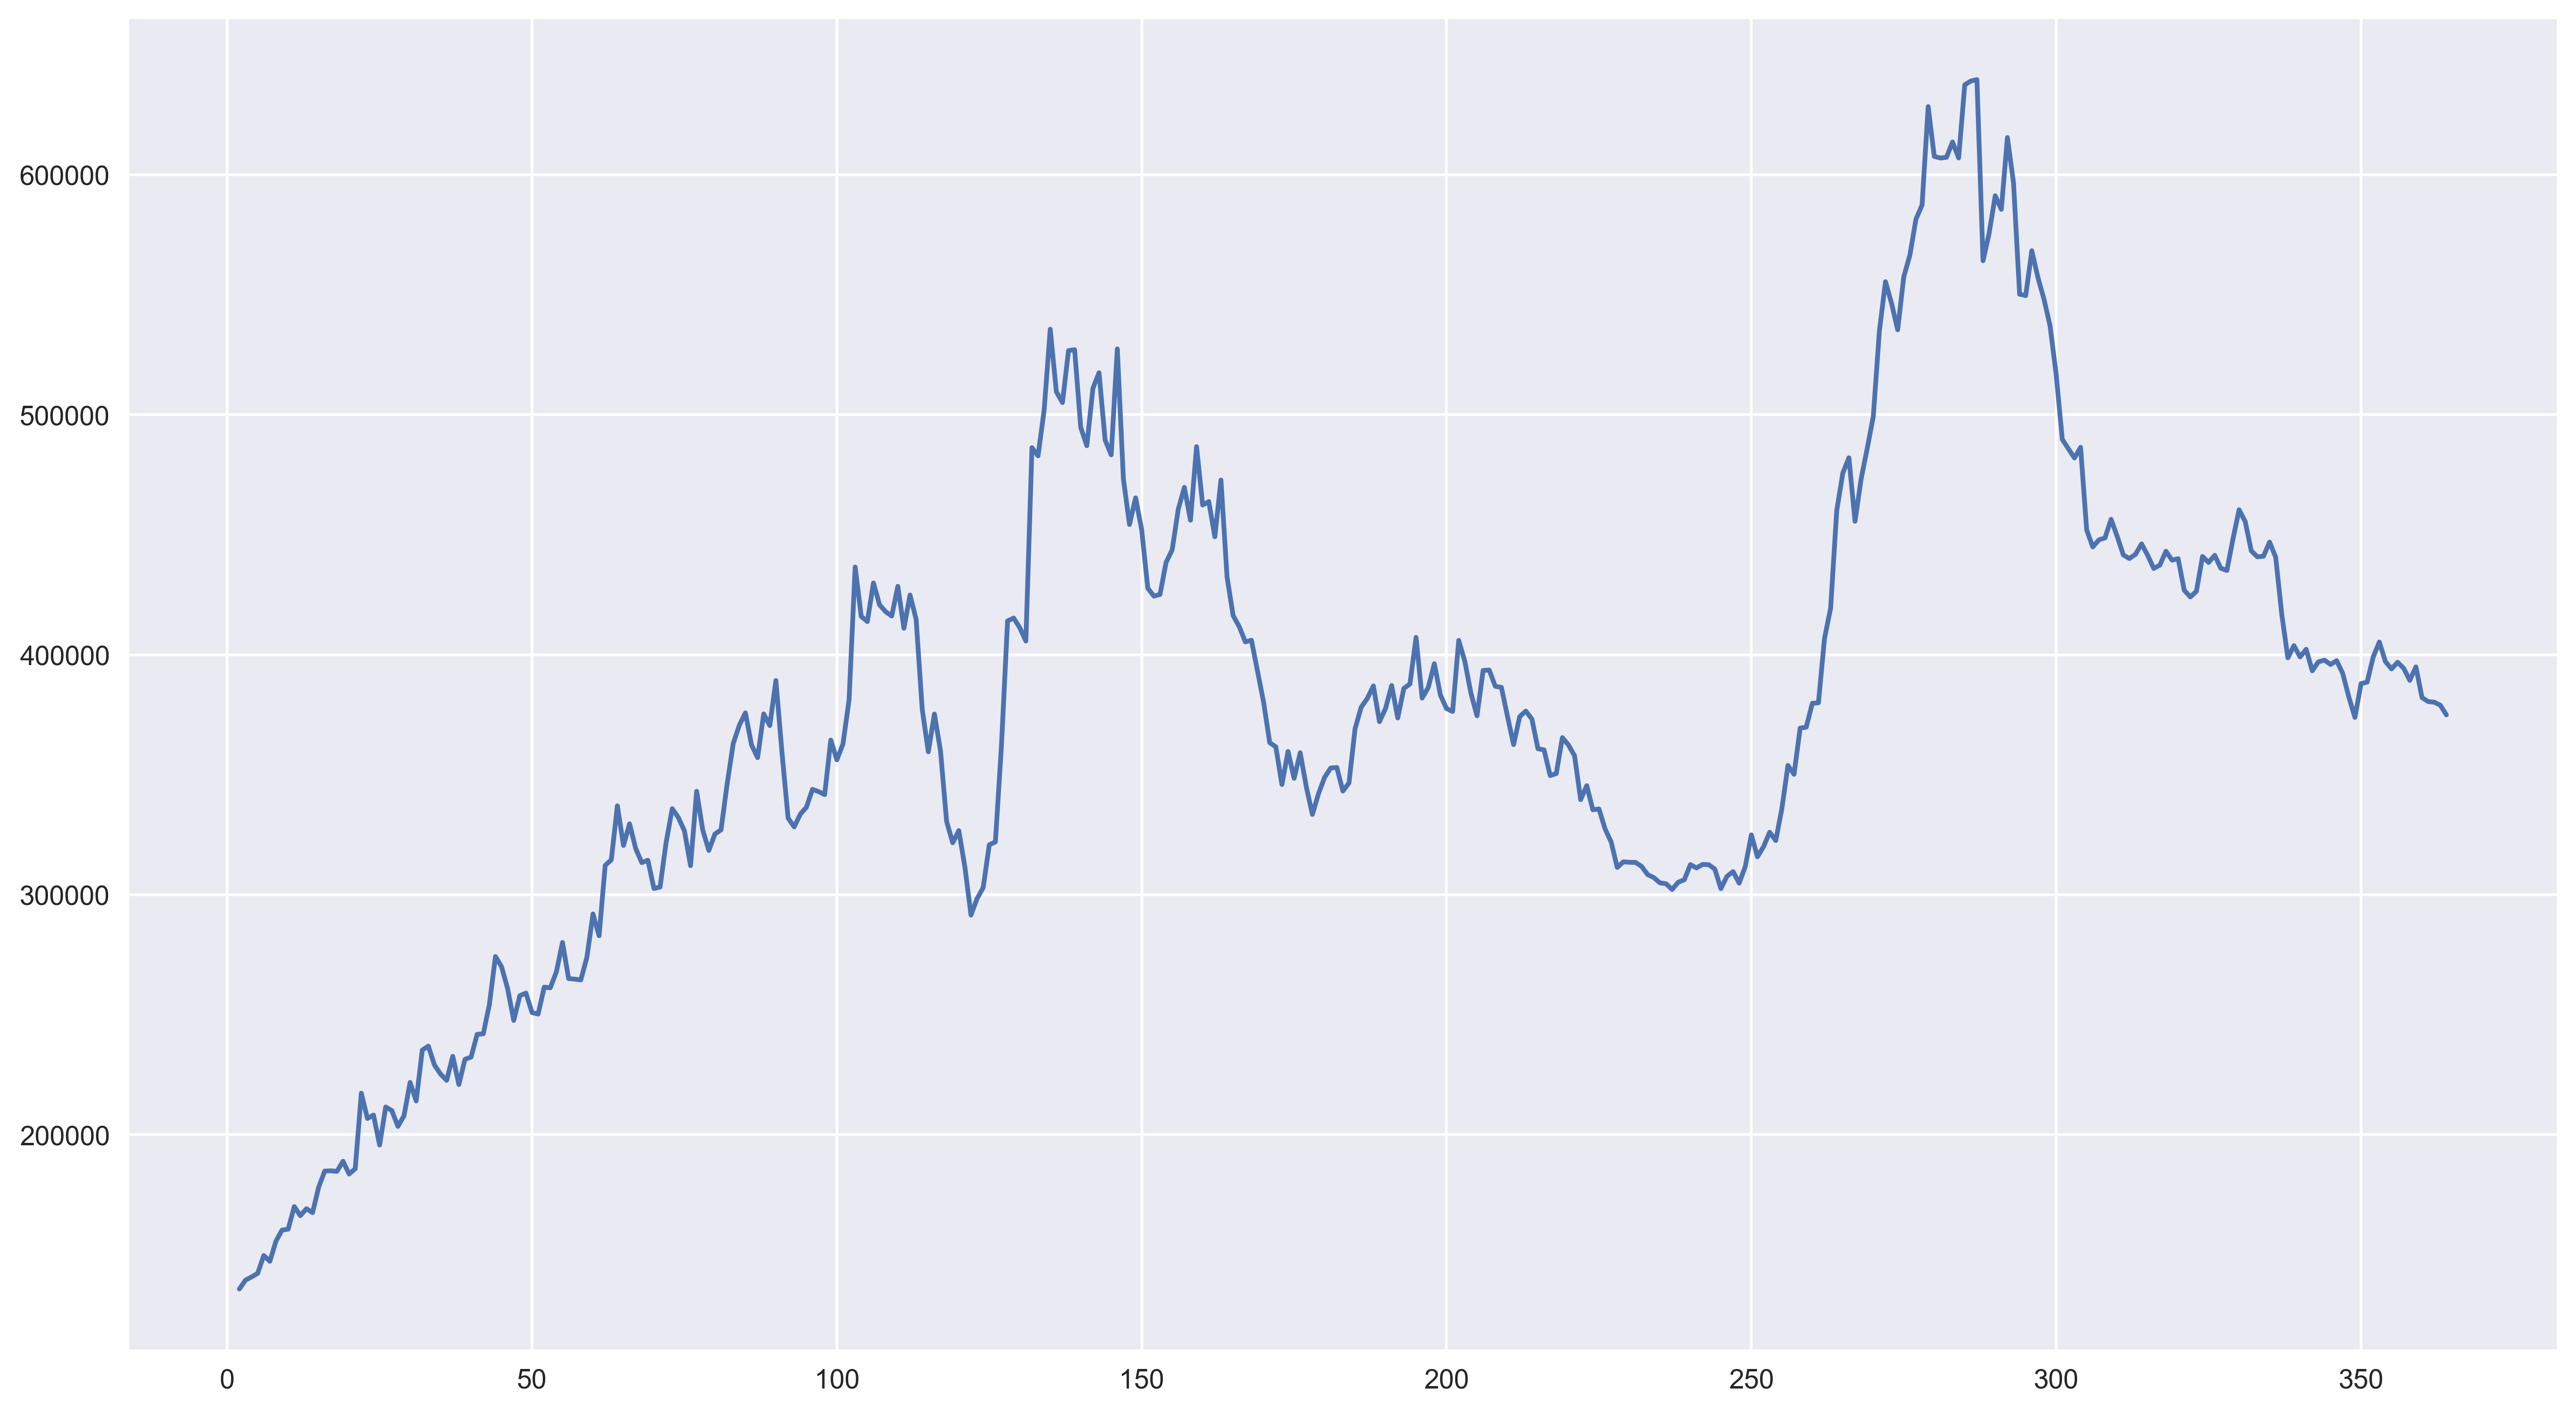

In [261]:
xlist = range(2, 365)

for i in range(0, 363):
    profit_0.append((profit[i] + profit_1[i] * k1 + profit_2[i] * k2 + profit_3[i] * k3 + profit_4[i] * k4 
                     + profit_5[i] * k5 + profit_6[i] * k6)/7)

ylist = profit_0
plt.plot(xlist, ylist)
plt.show()

In [275]:
xlist = range(2, 365)
ylist1 = profit
ylist2 = [i * k1 for i in profit_1]
ylist3 = [i * k2 for i in profit_2]
ylist4 = [i * k3 for i in profit_3]
ylist5 = [i * k4 for i in profit_4]
ylist6 = [i * k5 for i in profit_5]
ylist7 = [i * k6 for i in profit_6]
ylist0 = profit_0

plt.plot(xlist, ylist1, color='silver')
plt.plot(xlist, ylist2, color='silver')
plt.plot(xlist, ylist3, color='silver')
plt.plot(xlist, ylist4, color='silver')
plt.plot(xlist, ylist5, color='silver')
plt.plot(xlist, ylist6, color='silver')
plt.plot(xlist, ylist7, color='silver')
plt.plot(xlist, ylist0, color='black')
plt.show()

In [285]:
with open('output2/0.txt', 'w') as filehandle:
    for listitem in profit_0:
        filehandle.write('%s\n' % listitem)

# 5. Strategy B

## Определяем функции алгоритма

In [713]:
weights = [0.55, 0.25, 0.2]

In [714]:
def initialize(context):
    
    # устанавливаем комиссию за сделку
    context.set_commission(commission.PerDollar(cost=0.0007))
    
    set_benchmark(symbol('BTC'))
    
    context.assets = symbols('BTC', 'ETH', 'USDT')
    context.n_assets = len(context.assets)
    
    context.window = 0

    context.rebalance_period = 60
    context.time = 0

In [715]:
def handle_data(context, data):
    dic_weights = dict(zip(context.assets, weights)) 
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        # extract prices
        prices = data.history(context.assets, fields='price',
                               bar_count=context.window + 1, frequency='1d')

        # submit orders
        for asset in context.assets:
            order_target_percent(asset, dic_weights[asset])
    
    #record(weights=cleaned_weights)
    context.time += 1

## Запускаем алгоритм

In [716]:
threshold = zipline.run_algorithm(start=datetime(2015, 9, 1, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 11, 20, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000,
                              handle_data=handle_data,
                              data=panel)

In [717]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(threshold)

In [718]:
#threshold.columns

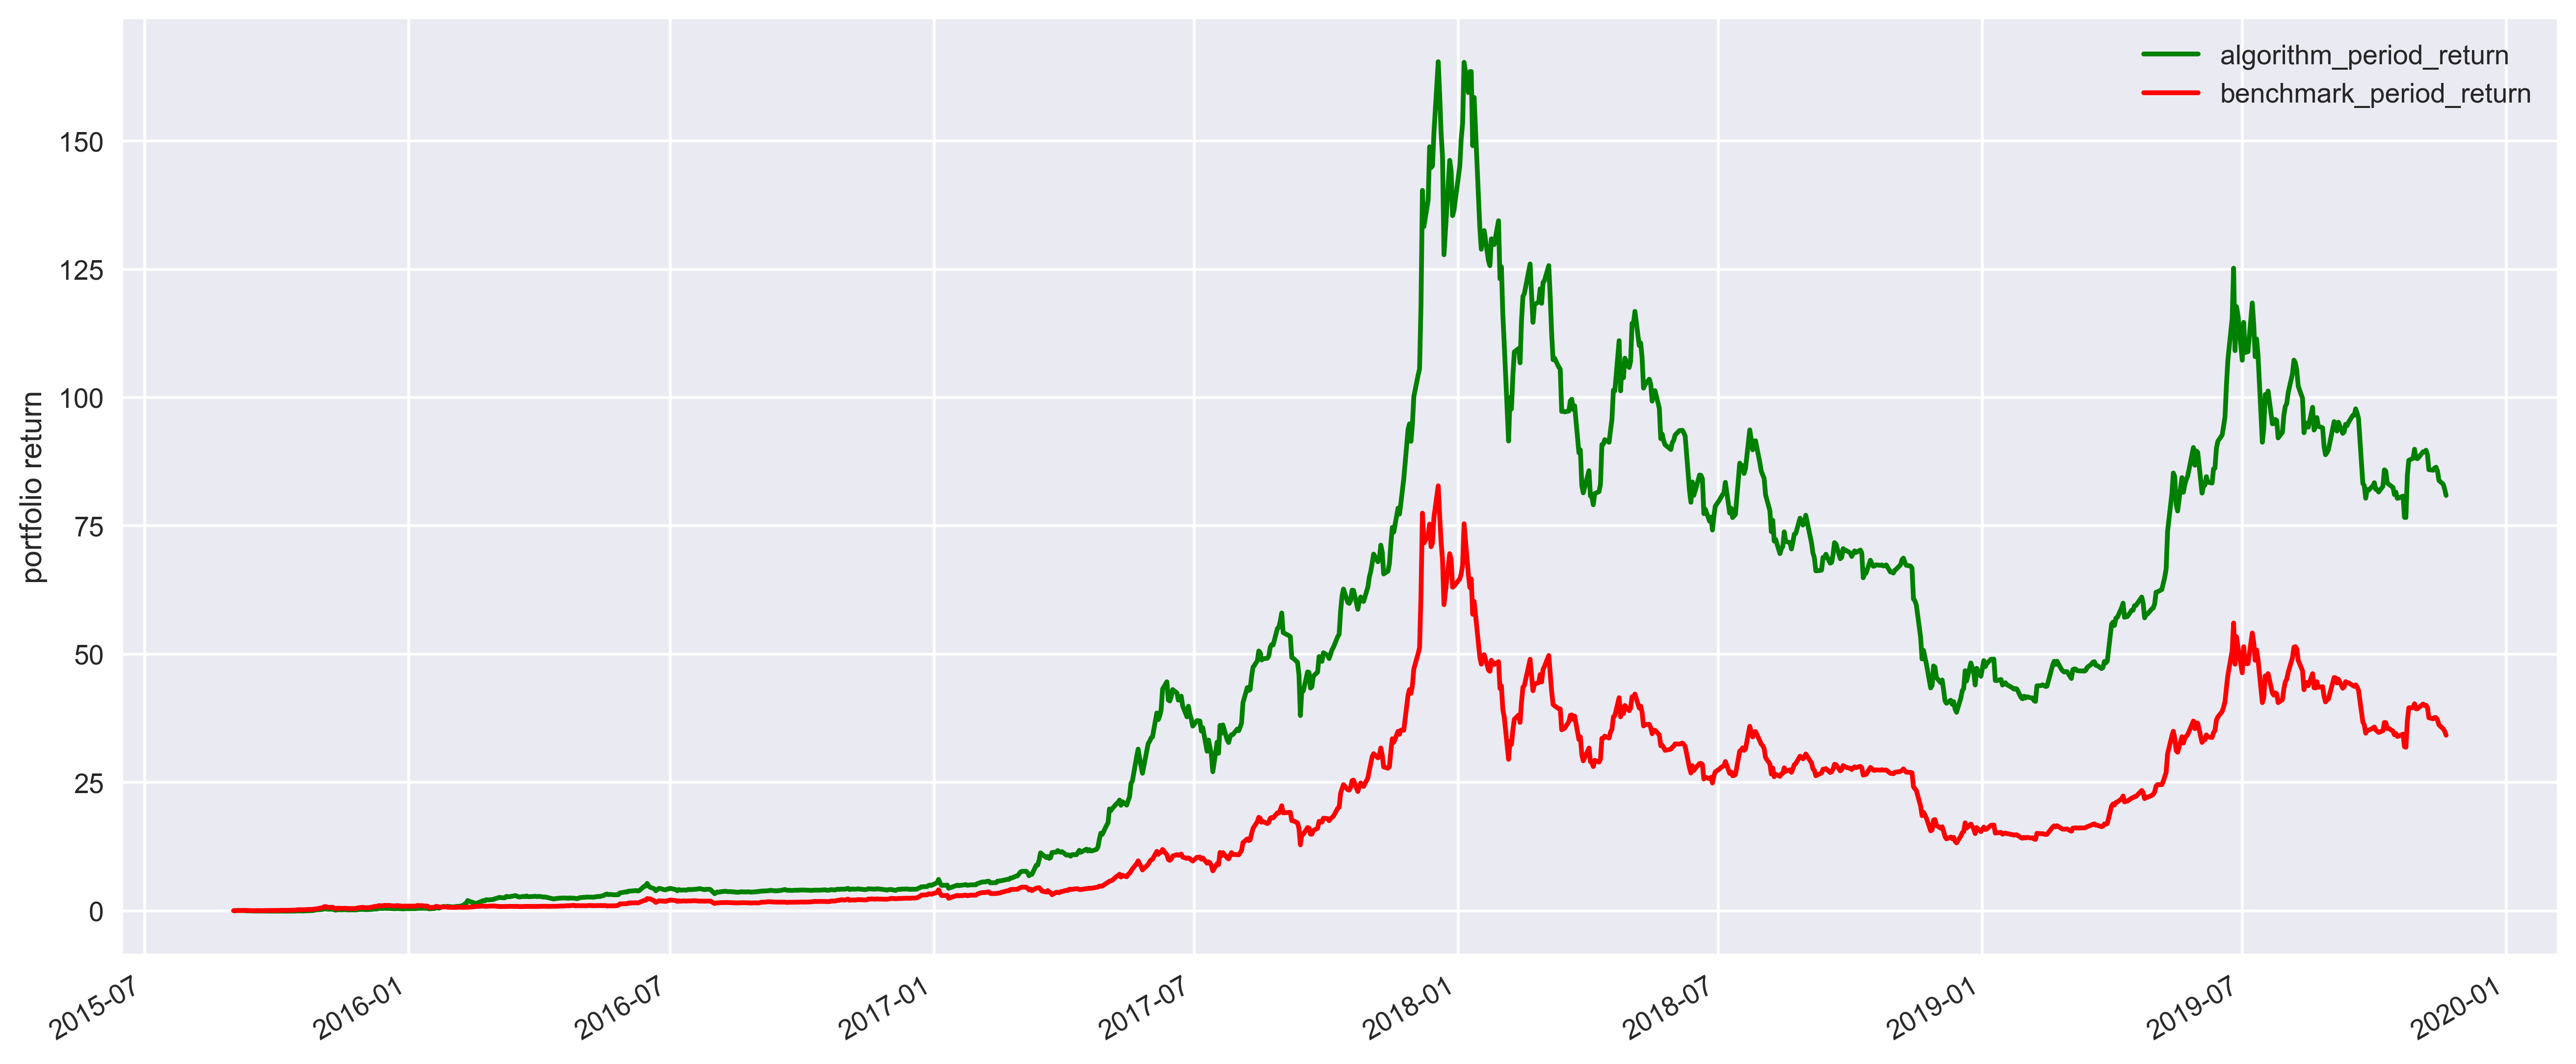

Final portfolio return: 8091.92%
Final benchmark return: 3418.86%


In [719]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
threshold.algorithm_period_return.plot(color='g')
threshold.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(threshold.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(threshold.benchmark_period_return[-1] * 100, 2)))

In [720]:
portfolio = 10000 * (1 + threshold.algorithm_period_return)
benchmark = 10000 * (1 + threshold.benchmark_period_return)

portfolio = portfolio.rename('portfolio')
benchmark = benchmark.rename('benchmark') 

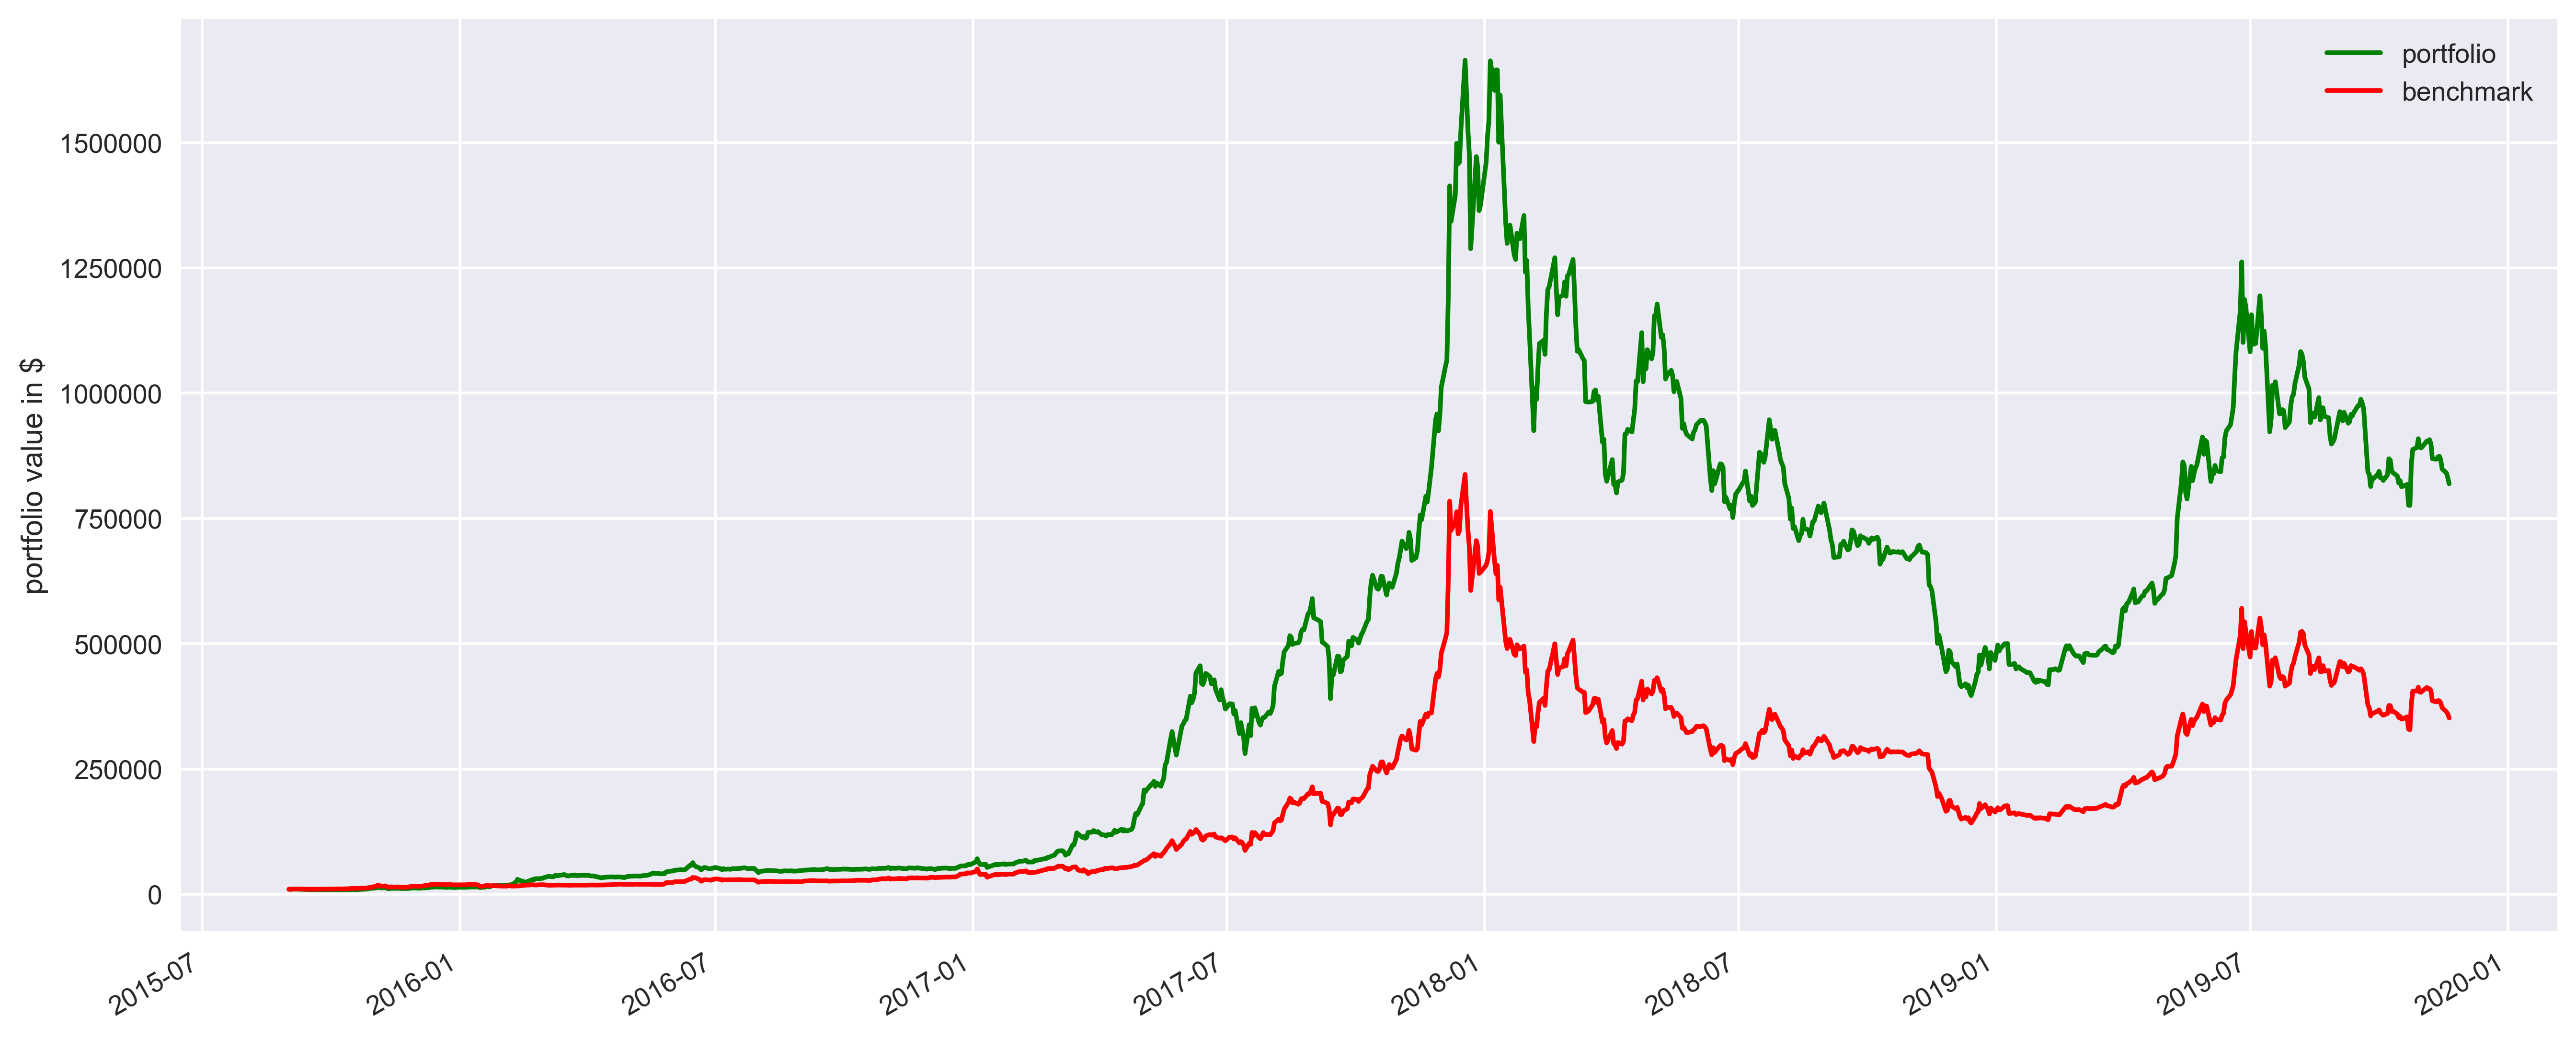

Final portfolio value (including cash): 819191.93$
Final benchmark value: 351886.41$


In [721]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
portfolio.plot(color='g')
benchmark.plot(color='r')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(threshold.portfolio_value[-1], 2)))
print('Final benchmark value: {}$'.format(np.round(benchmark[-1], 2)))

In [722]:
fig, ax = plt.subplots(figsize=[16, 7])

threshold.algo_volatility.plot(color='g')
threshold.benchmark_volatility.plot(color='r')

plt.legend()
plt.show()

print('algo_volatility = {}%'.format(np.round(threshold.algo_volatility[-1] * 100), 2))
print('benchmark_volatility = {}%'.format(np.round(threshold.benchmark_volatility[-1] * 100), 2))

algo_volatility = 68.0%
benchmark_volatility = 73.0%


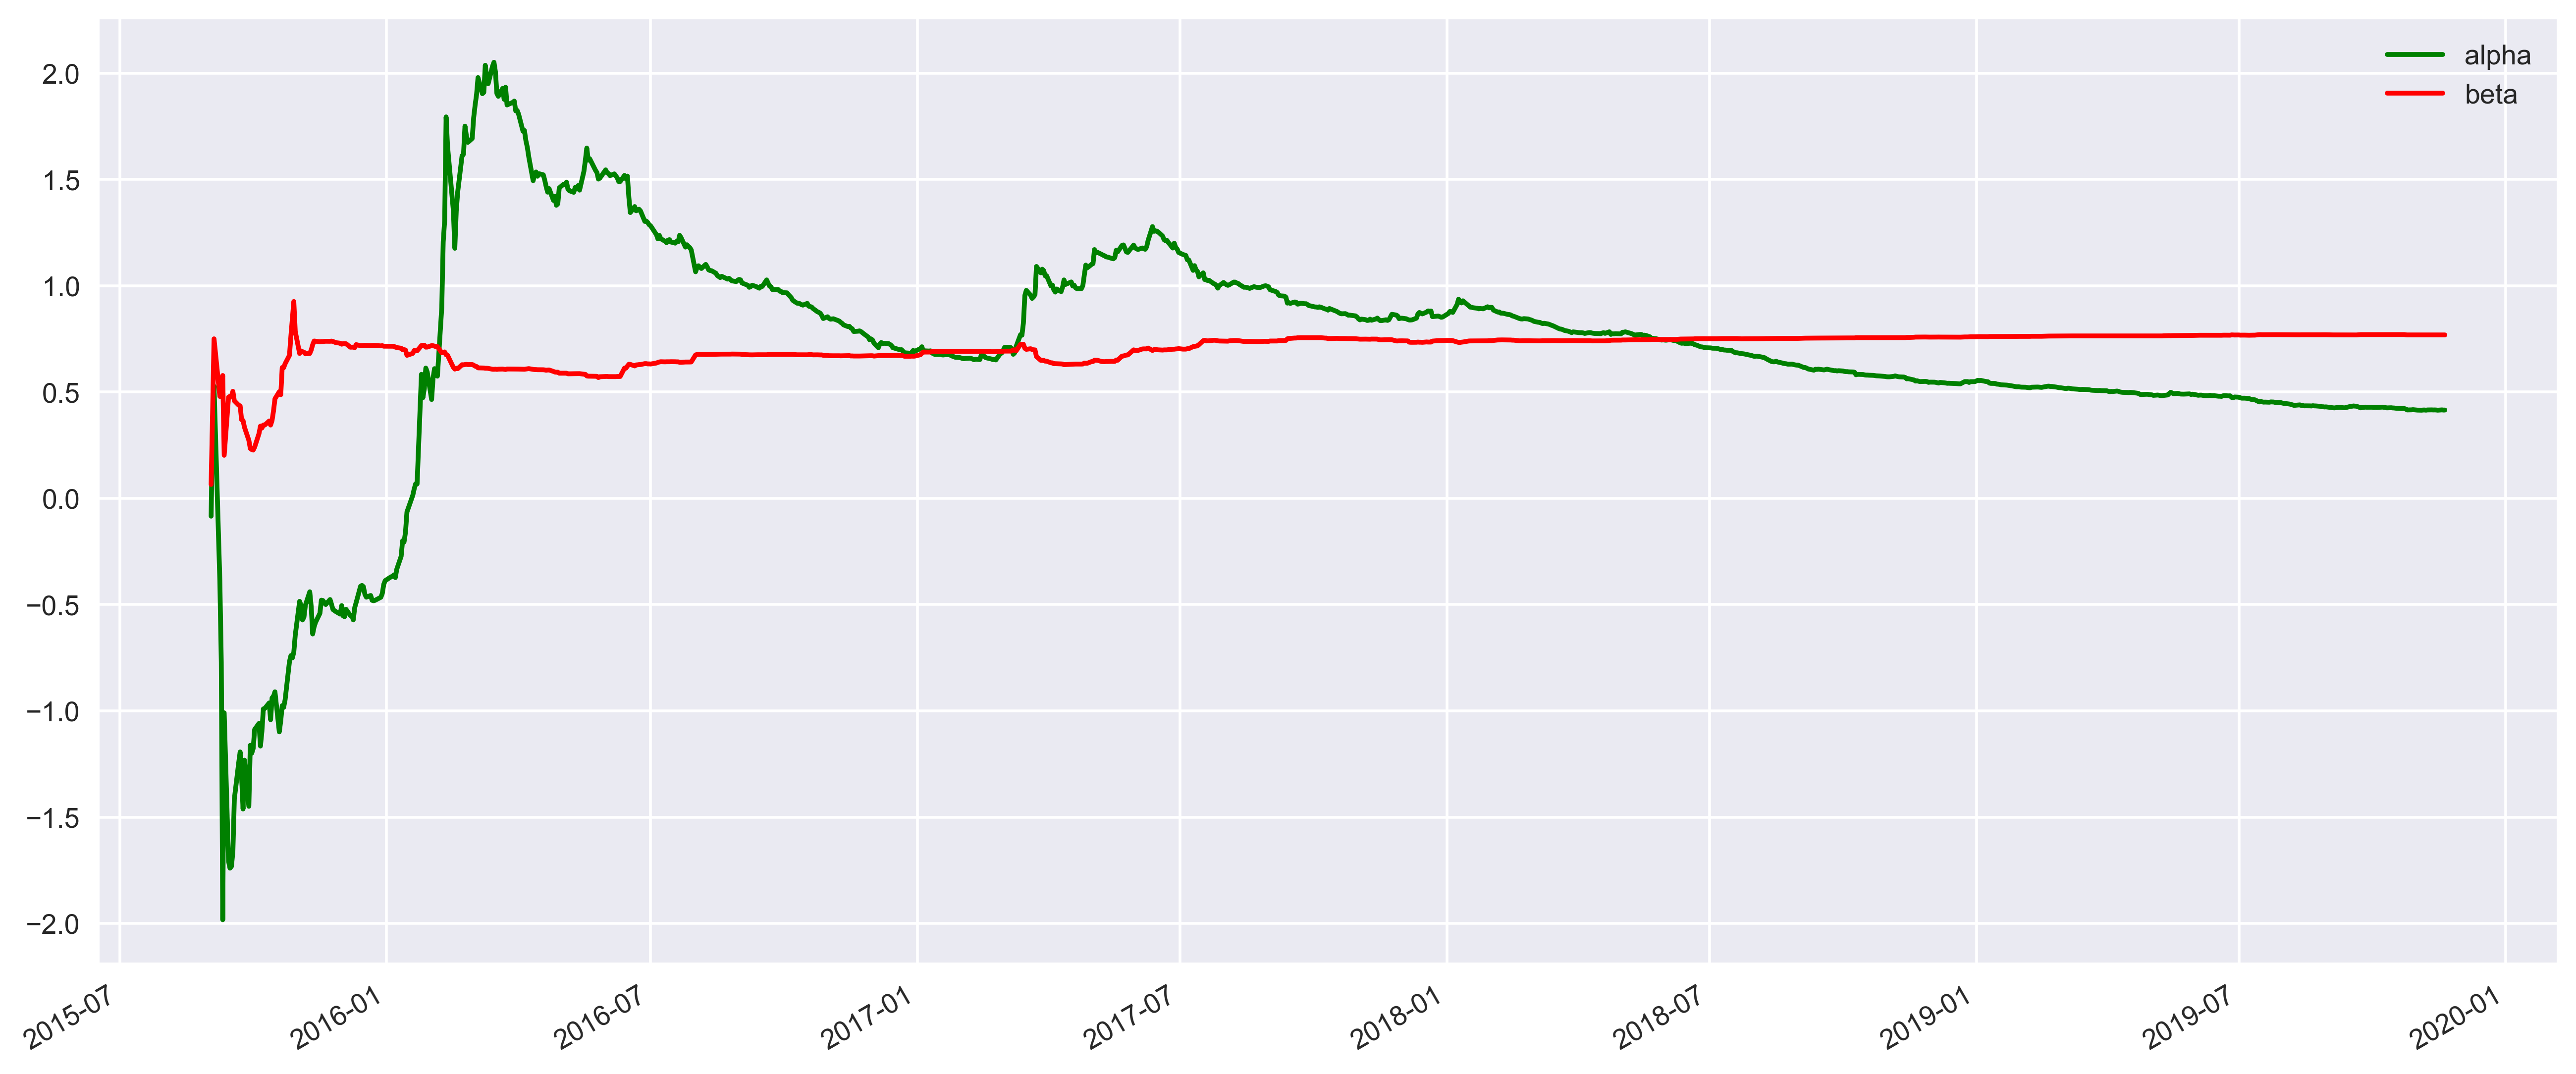

alpha = 0.42
beta = 0.77


In [723]:
fig, ax = plt.subplots(figsize=[16, 7])

threshold.alpha.plot(color='g')
threshold.beta.plot(color='r')

plt.legend()
plt.show()

print('alpha = {}'.format(np.round(threshold.alpha[-1], 2)))
print('beta = {}'.format(np.round(threshold.beta[-1], 2)))

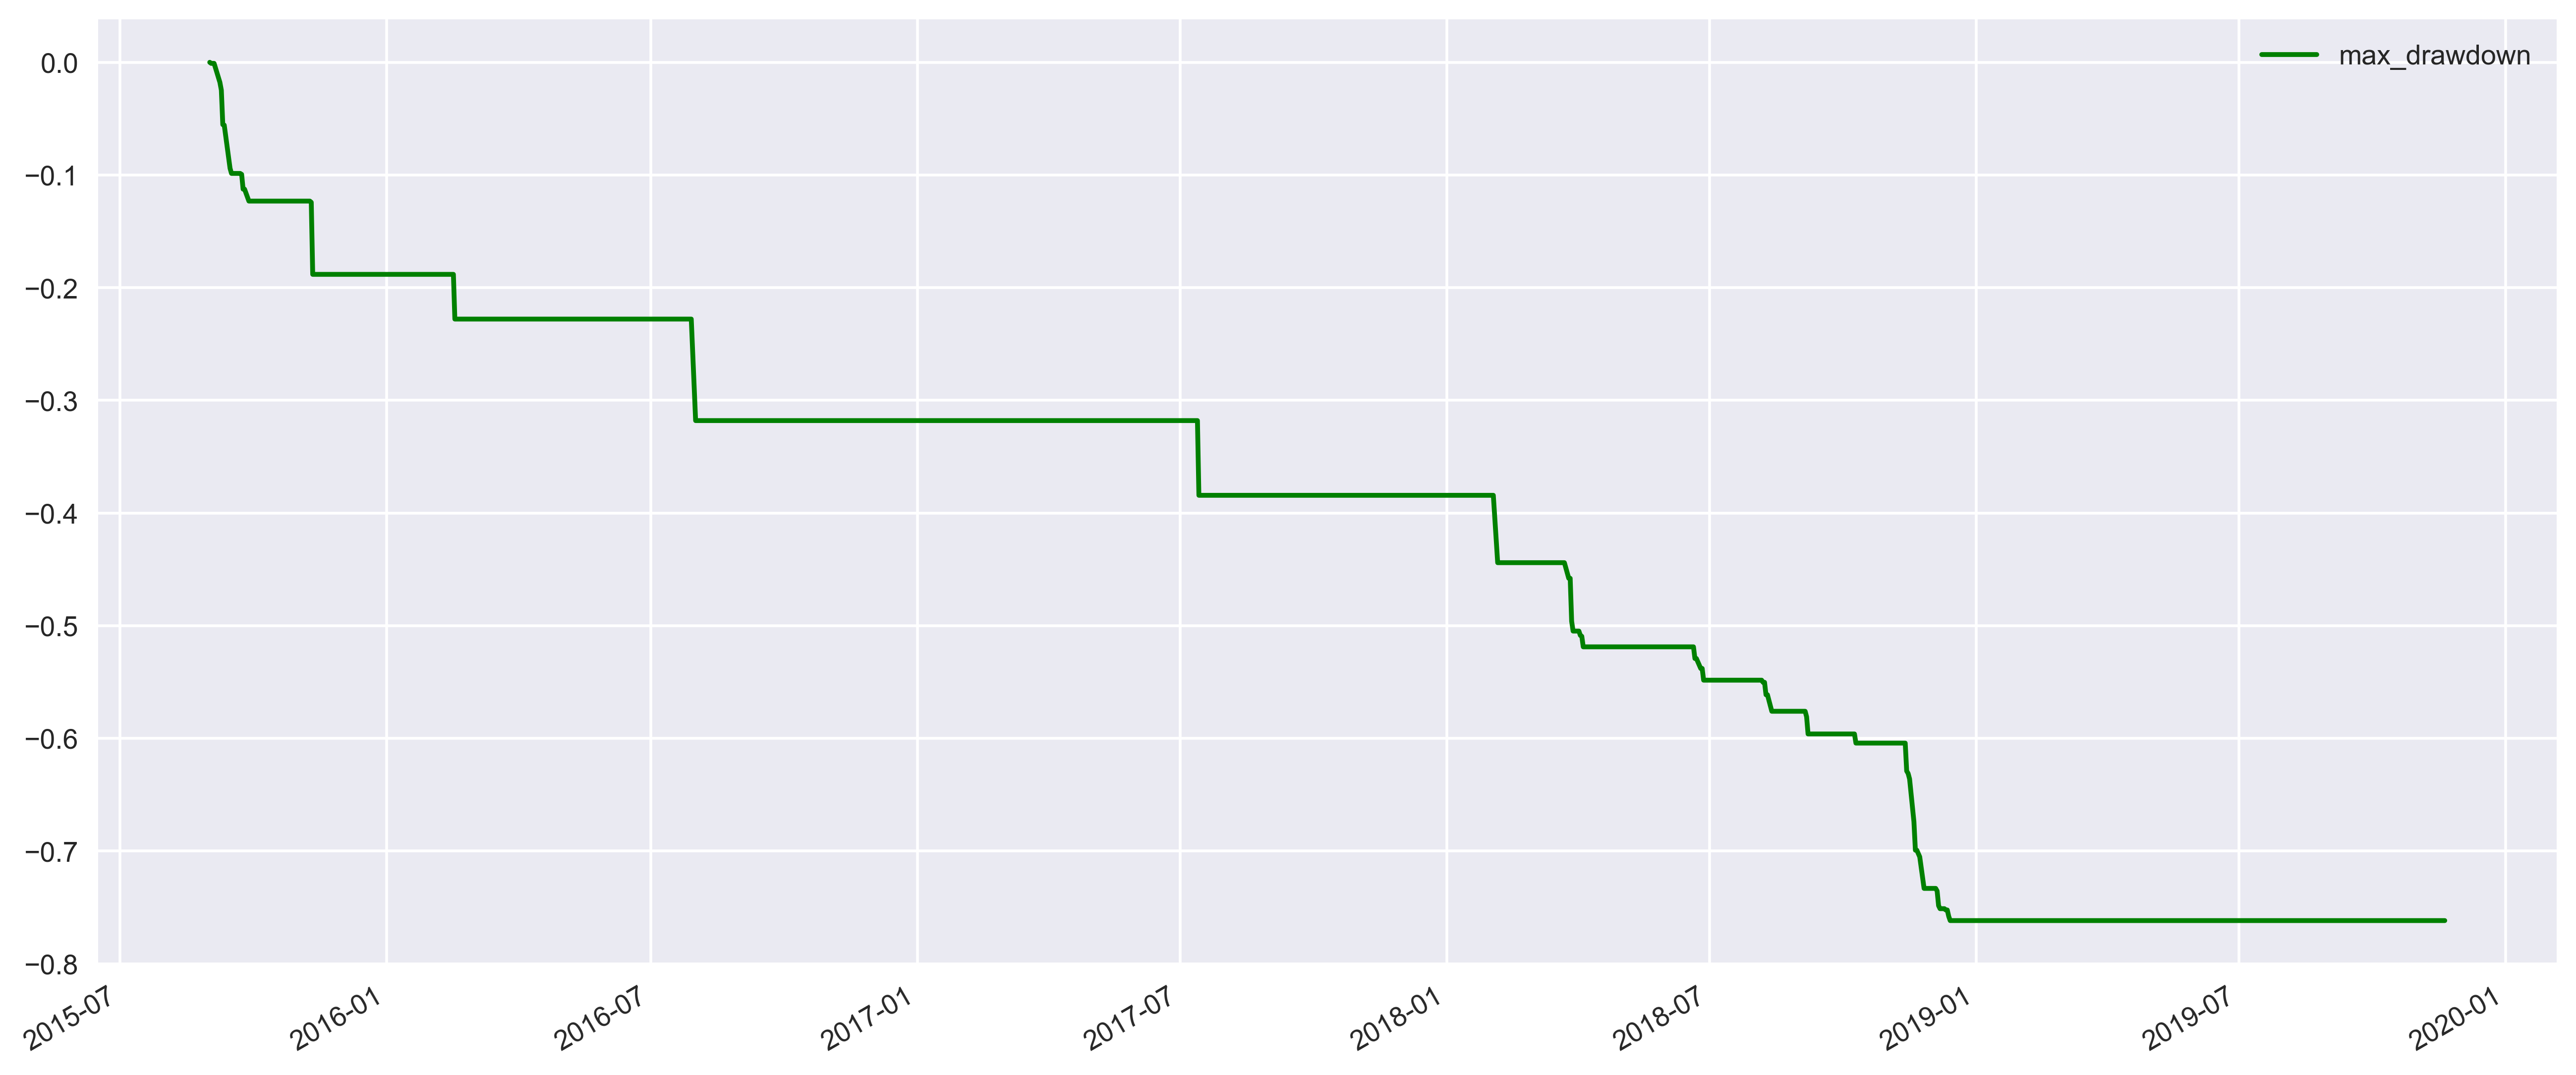

In [724]:
fig, ax = plt.subplots(figsize=[16, 7])

threshold.max_drawdown.plot(color='g')

plt.legend()
plt.show()

In [725]:
fig, ax = plt.subplots(figsize=[16, 7])

threshold.sharpe.plot(color='g')

plt.legend()
plt.show()
print('Sharpe =', np.round(threshold.sharpe[-1], 2))

Sharpe = 1.87


In [726]:
fig, ax = plt.subplots(figsize=[16, 7])

threshold.returns.plot(color='g')

plt.legend()
plt.show()

In [727]:
pf.plot_drawdown_periods(returns, top=5)

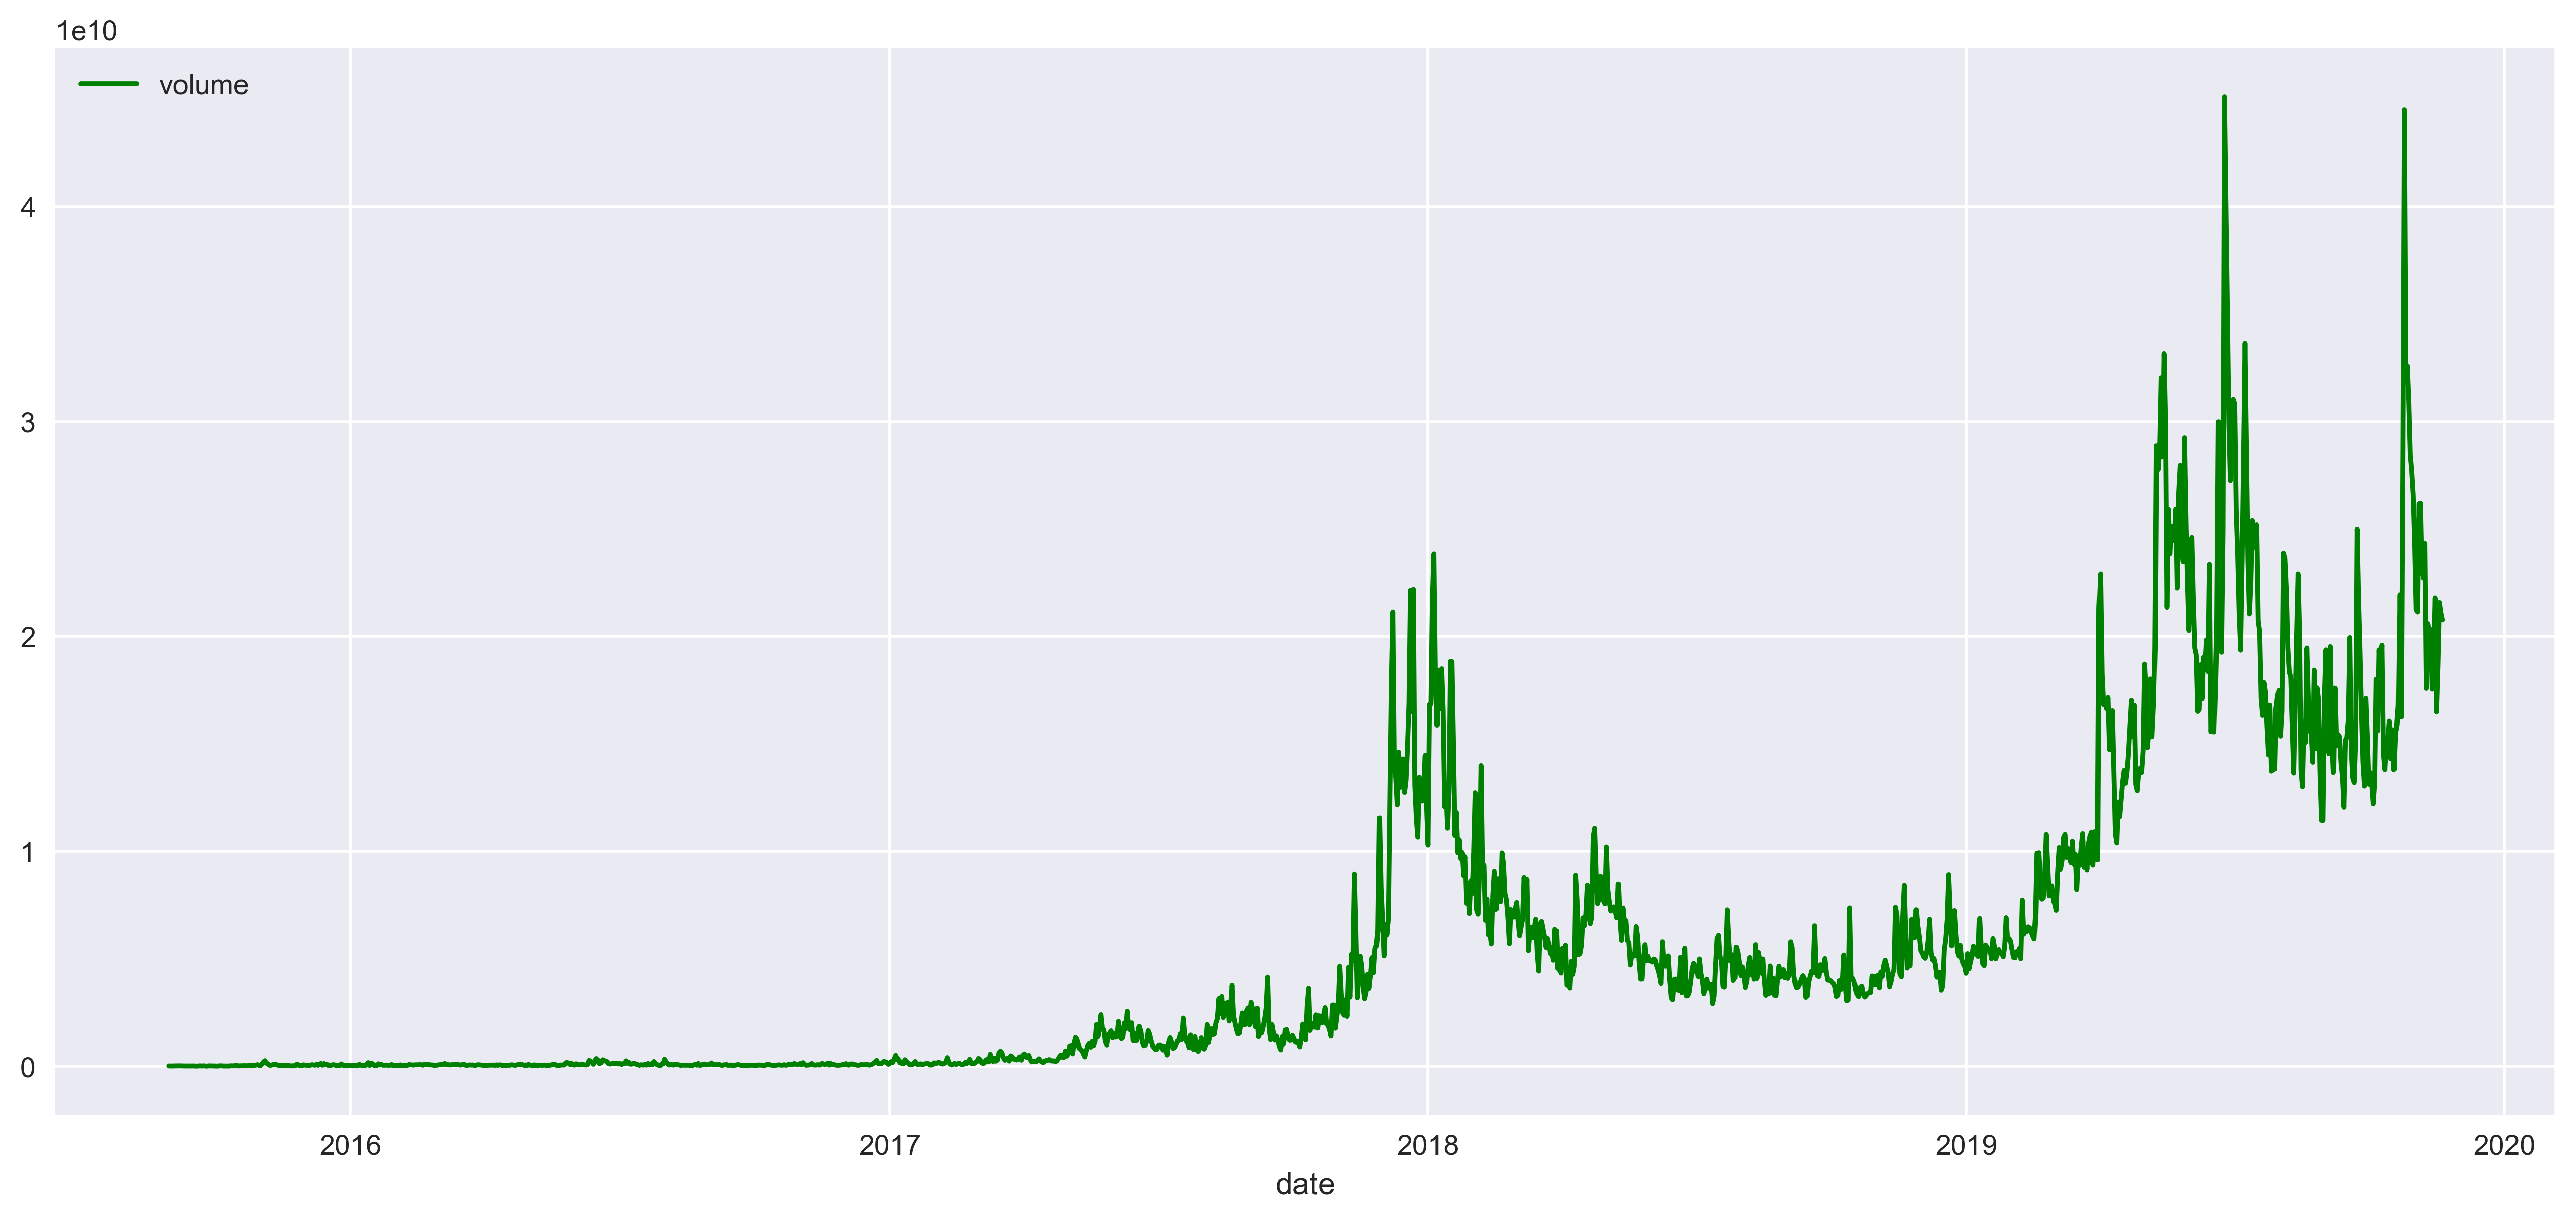

Sharpe = 1.87


In [729]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'].plot(color='g')

plt.legend()
plt.show()
print('Sharpe =', np.round(threshold.sharpe[-1], 2))